In [7]:
%matplotlib notebook
import vtk
from Parser import Parser
from ipycanvas import Canvas
from typing import Dict, Callable, Tuple, List
from ipywidgets import Image, Output
import ipywidgets as widgets
import numpy as np
import math
import asyncio
from time import time
from vtk.util import numpy_support
import matplotlib.pyplot as plt
plt.ion()

output = Output()

figureNumber = 0

MOVE_ACTION = 'move'
ZOOM_ACTION = 'zoom'
SELECT_ACTION = 'select'
ROTATE_ACTION = 'rotate'

VISIBLE_CELL = "cell"

##################################################################### UTILS ####################################

def defaultColorMap(cells, variables):
    return [
        ('#004400', 'green', cells[variables['cycle_model']] == 5),
        ('brown', 'black', cells[variables['cycle_model']] == 100),
        ('#440000', 'red', cells[variables['cycle_model']] == 101)
    ]

def noFilter(cells, variables):
    return np.full(cells.shape[1], True)

def count(array):
    dic = {}
    for num in array:
        if not num in dic:
            dic[num] = 0
        dic[num] += 1
    return dic

class Timer:
    def __init__(self, timeout, callback):
        self._timeout = timeout
        self._callback = callback

    async def _job(self):
        await asyncio.sleep(self._timeout)
        self._callback()

    def start(self):
        self._task = asyncio.ensure_future(self._job())

    def cancel(self):
        self._task.cancel()

def debounce(wait):
    """ Decorator that will postpone a function's
        execution until after `wait` seconds
        have elapsed since the last time it was invoked. """
    def decorator(fn):
        timer = None
        lastCall = time()
        def debounced(*args, **kwargs):
            nonlocal timer
            nonlocal lastCall
            def call_it():
                fn(*args, **kwargs)
            if timer is not None:
                timer.cancel()
            if time() - lastCall >= wait:
                lastCall = time()
                if timer is not None:
                    timer.cancel()
                call_it()
            else:
                timer = Timer(wait, call_it)
                timer.start()
        return debounced
    return decorator

@output.capture()
def defaultColorMap3d(cells, variables, selectedCellId):
    tags = vtk.vtkFloatArray()
    colors = np.zeros(cells.shape[1]) + (cells[variables['cycle_model']] == 5) + 2 * (cells[variables['cycle_model']] == 100) + 3 * (cells[variables['cycle_model']] == 101)
    if selectedCellId is not None:
        colors[cells[variables['ID']] == selectedCellId] = 4
    for cell in colors:
        tags.InsertNextValue(float(cell))
    
    
    colorTransferFunction = vtk.vtkColorTransferFunction()
    colorTransferFunction.AddRGBPoint(0.0, 0.0, 0.0, 0.0)
    colorTransferFunction.AddRGBPoint(1.0, 0.0, 1.0, 0.0)
    colorTransferFunction.AddRGBPoint(2.0, 165.0, 42.0, 42.0)
    colorTransferFunction.AddRGBPoint(3.0, 1.0, 0.0, 0.0)
    colorTransferFunction.AddRGBPoint(4.0, 1.0, 1.0, 1.0)
    
    return tags, colorTransferFunction

def defaultEnvironment(environment, attribute):
    xbounds = environment.mesh.boundsX
    ybounds = environment.mesh.boundsY
    zbounds = environment.mesh.boundsZ

    attributeIndex = environment.current.variables[attribute]

    positions = environment.mesh.voxels
    data = environment.current.data[attributeIndex]

    xCount = np.unique(environment.mesh.voxels[environment.mesh.variables['x']]).shape[0]
    yCount = np.unique(environment.mesh.voxels[environment.mesh.variables['y']]).shape[0]
    zCount = np.unique(environment.mesh.voxels[environment.mesh.variables['z']]).shape[0]

    minimum = np.min(data)
    maximum = np.max(data)
    
    if not maximum == 0:
        data = data / maximum

    data = np.reshape(data, (xCount, yCount, zCount))

    imdata = vtk.vtkImageData()
    depthArray = numpy_support.numpy_to_vtk(data.ravel(), deep=True, array_type=vtk.VTK_DOUBLE)

    imdata.SetDimensions(data.shape)
    imdata.SetSpacing([(xbounds[1] - xbounds[0]) / xCount, (ybounds[1] - ybounds[0]) / yCount, (zbounds[1] - zbounds[0]) / zCount])
    imdata.SetOrigin([xbounds[0], ybounds[0], zbounds[0]])
    imdata.GetPointData().SetScalars(depthArray)

    colorFunc = vtk.vtkColorTransferFunction()
    colorFunc.AddRGBPoint(0.0, 0.0, 0.0, 0.0)
    colorFunc.AddRGBPoint(1.0, 1.0, 1.0, 1.0)

    opacity = vtk.vtkPiecewiseFunction()
    opacity.AddPoint(0.0, 0.0)
    opacity.AddPoint(1, 0.8)

    volumeProperty = vtk.vtkVolumeProperty()
    volumeProperty.SetColor(colorFunc)
    volumeProperty.SetScalarOpacity(opacity)
    volumeProperty.SetInterpolationTypeToLinear()
    volumeProperty.SetIndependentComponents(2)

    volumeMapper = vtk.vtkFixedPointVolumeRayCastMapper()
    volumeMapper.SetInputData(imdata)
    volumeMapper.SetBlendModeToMaximumIntensity()


    volume = vtk.vtkVolume()
    volume.SetMapper(volumeMapper)
    volume.SetProperty(volumeProperty)
    
    return volume

##################################################################### BASE INTERACTOR ####################################

class Interactor:
    def __init__(self, parser, width, height, colorMap, filterFunction, availableActions):
        self._currentFrame = parser.getFrameRange()[0]
        self._canvas = Canvas(width=width, height=height)
        self._parser = parser
        self._colorMap = colorMap
        self._height = height
        self._width = width
        self._filterFunction = filterFunction
        
        self._cellFigure = None
        
        frame = parser.getFrame(self._currentFrame)
        mesh = frame.environment.mesh
        self._availableEnvironments = [*frame.environment.current.attributes]
        
        self._canvas.on_mouse_down(self._onMouseDown)
        self._canvas.on_mouse_move(self._onMouseMove)
        self._canvas.on_mouse_up(self._onMouseUp)
        self._canvas.on_mouse_out(self._onMouseOut)
        
        self.action = availableActions[0]
        
        self._buttons = widgets.RadioButtons(
            options=availableActions,
            value=self.action,
            description='Mouse Action:',
            disabled=False,
        )
        self._buttons.observe(self.onToolChange, names='value')
        
        self._visible = (VISIBLE_CELL,)
        self._environmentButtons = widgets.SelectMultiple(
            options=[VISIBLE_CELL, *self._availableEnvironments],
            description='Visible:',
            disabled=False,
            value=[VISIBLE_CELL],
        )
        self._environmentButtons.observe(self.onVisibilityChange, names='value')
        
        self._availableAttributes = [*frame.cells.variables.keys()]
        self._selectedAttribute = self._availableAttributes[0]
        self._previousSelectedAttribute = None
        self._previousSelectedAttributeCell = None
        self._attributes = widgets.RadioButtons(
            options=self._availableAttributes,
            value=self._selectedAttribute,
            description='Generate Attribute Graph:\n',
            disabled=False,
        )
        self._attributes.observe(self.onAttriChange, names='value')

        self._frameSelector = widgets.IntSlider(
            value=self._currentFrame,
            min=parser.getFrameRange()[0],
            max=parser.getFrameRange()[1] - 1,
            step=1,
            description='Frame:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        self._frameSelector.observe(self.onFrameChange, names='value')
        
        self._clicking = False
        self._dragStartX = 0
        self._dragStartY = 0
        self._actionOriginX = 0
        self._actionOriginY = 0
        
        self._selectedCell = None
    
    def setColorMap(colorMap):
        self._colorMap = colorMap
        self.update()
    
    def setFilterFunction(filterFunction):
        self._filterFunction = filterFunction
        self.update()
    
    def onToolChange(self, action):
        self.action = action.new
    
    @output.capture()
    def onVisibilityChange(self, action):
        self._visible = action.new
        self.update()
        
    @output.capture()    
    def onAttriChange(self, action):
        self._selectedAttribute = action.new
        self._updateCellPlot()
        
    @output.capture()
    def _updateCellPlot(self):
        if (self._previousSelectedAttribute == self._selectedAttribute and self._previousSelectedAttributeCell == self._selectedCell) or self._selectedCell is None:
            return
        
        self._previousSelectedAttribute = self._selectedAttribute
        self._previousSelectedAttributeCell = self._selectedCell
        
        data = []
        timestamps = []
        time = 0
        variables = self.getCellVariables()
        for frameNumber in range(*self._parser.getFrameRange()):
            cell = self.getSelectedCell(frameNumber)
            data.append(cell[variables[self._selectedAttribute]])
            timestamps.append(time)
            time += 1
            
        if self._cellFigure is not None:
            self._cellAx.clear()
            ln, = self._cellAx.plot(timestamps, data)
            plt.xlabel('time', axes=self._cellAx)
            plt.ylabel(self._selectedAttribute, axes=self._cellAx)
            plt.title(self._selectedAttribute + " for cell " + str(int()))
            ln.set_color('orange')
        
        
    def onFrameChange(self, action):
        self._currentFrame = action.new
        self.update()
    

    def getCellVariables(self, frame: int = None):
        if frame is None:
            frame = self._currentFrame
        return self._parser.getFrame(frame).cells.variables
    
    def getCell(self, cellId: int, frame: int = None):
        if frame is None:
            frame = self._currentFrame
        cells = self.getCells(frame)
        variables = self.getCellVariables()
        cellColumn = cells[variables['ID']] == cellId
        return cells[:,cellColumn].reshape(-1)
    
    def getCells(self, frame: int = None):
        if frame is None:
            frame = self._currentFrame
        return self._parser.getFrame(frame).cells.data
    
    def getCellsToRender(self, frame: int = None):
        cells = self.getCells(frame)
        
        if self._filterFunction:
            cellVariables = self.getCellVariables(frame)
            cells = cells[:,self._filterFunction(cells, cellVariables)]
        
        return cells
    
    def getSelectedCell(self, frame: int = None):
        if self._selectedCell is None:
            return None
        
        return self.getCell(self._selectedCell, frame)
    
    @output.capture()
    def _onMouseDown(self, x: int, y: int):
        self._dragStartX = x
        self._dragStartY = y
        self._actionOriginX = x
        self._actionOriginY = y
        
        self.onMouseDown(x, y)
        
        if self.action == SELECT_ACTION:
            self.selectCell(x, y)
        else:
            self._clicking = True
    
    def selectCell(self, x: int, y: int):
        pass
    
    def _onMouseUp(self, x: int, y: int):
        self._clicking = False
        self.onMouseUp(x, y)
    
    def _onMouseOut(self, x: int, y: int):
        self._clicking = False
        self.onMouseOut(x, y)
    
    @output.capture()
    def _onMouseMove(self, x: int, y: int):
        self.onMouseMove(x, y)
    
    def onMouseUp(self, x: int, y: int):
        pass

    def onMouseOut(self, x: int, y: int):
        pass
    
    def onMouseMove(self, x: int, y: int):
        pass
    
    def onMouseDown(self, x: int, y: int):
        pass
        
    def update(self):        
        canvas = self._canvas
        
        selectedCell = self.getSelectedCell()
        if selectedCell is not None:
            cellVaraibles = self.getCellVariables()
            
            canvas.fill_style = '#A0A0A0'
            canvas.font = '10px serif'
            
            
            identity = selectedCell[cellVaraibles["ID"]]
            volume = selectedCell[cellVaraibles["total_volume"]]
            phase = selectedCell[cellVaraibles["current_phase"]]
            
            canvas.fill_text(f"(ID: {identity}, Volume: {volume}, Phase: {phase})", 10, self._height - 10)
            
        self._updateCellPlot()
    
    def radiusOfCells(self, cells, variables):
        return (cells[variables['total_volume']] * (3 / ( 4 * math.pi))) ** (1 / 3)
    
    def show(self):
        display(self._canvas, self._buttons, self._frameSelector,self._attributes, self._environmentButtons, output)
        if self._cellFigure is None:
            global figureNumber
            fig, ax = plt.subplots()
            self._cellAx = ax
            self._cellFigure = fig
            figureNumber += 1

##################################################################### 2D INTERACTOR ####################################

class Interactor2D(Interactor):
    def __init__(self, parser, width: int = 500, height: int = 400, colorMap = defaultColorMap, filterFunction = None, backgroundColorRGB = "black"):
        super().__init__(parser, width, height, colorMap, filterFunction, (MOVE_ACTION, ZOOM_ACTION,SELECT_ACTION))

        frame = parser.getFrame(self._currentFrame)
        mesh = frame.environment.mesh
        self._zoom = max((mesh.boundsX[1] - mesh.boundsX[0]) / width, (mesh.boundsY[1] - mesh.boundsY[0]) / height)
        
        self._xOffset = mesh.boundsX[0]
        self._yOffset = mesh.boundsY[0]
        
        self._buffer = Canvas(width=width, height=height)
        
        self._backgroundColor = backgroundColorRGB
        
        self.update()
    
    @output.capture()
    def drawEnvironment(self, attribute, rRange=(0,0), gRange=(0,255), bRange=(0,255), aRange=(0, 255)):
        if attribute is None:
            return
        canvas = self._canvas
        
        canvas.save()
        
        environment = self._parser.getFrame(self._currentFrame).environment

        xbounds = environment.mesh.boundsX
        ybounds = environment.mesh.boundsY
        
        attributeIndex = environment.current.variables[attribute]

        positions = environment.mesh.voxels
        data = environment.current.data[attributeIndex]

        xCount = np.unique(environment.mesh.voxels[environment.mesh.variables['x']]).shape[0]
        yCount = np.unique(environment.mesh.voxels[environment.mesh.variables['y']]).shape[0]

        minimum = np.min(data)
        maximum = np.max(data)

        shapedData = np.reshape(data / maximum, (xCount, yCount))

        image_data = np.stack((shapedData * (rRange[1] - rRange[0]) + rRange[0], shapedData * (gRange[1] - gRange[0]) + gRange[0], shapedData * (bRange[1] - bRange[0]) + bRange[0], shapedData * (aRange[1] - aRange[0]) + aRange[0]), axis=2)
        image_data = image_data.astype(dtype=np.int32)

        canvas.save()
        
        scale = (xbounds[1] - xbounds[0]) / ( xCount * self._zoom )
        
        canvas.scale( scale )
        
        x = (xbounds[0] - self._xOffset) / (scale * self._zoom)
        y = (ybounds[0] - self._yOffset) / (scale * self._zoom)

        canvas.put_image_data(image_data, x,  y)

        canvas.restore()
    
    def drawCells(self):
        canvas = self._canvas
    
        cells = self.getCellsToRender()
        cellVariables = self.getCellVariables()

        x = (cells[cellVariables['position.x']] - self._xOffset) / self._zoom
        y = (cells[cellVariables['position.y']] - self._yOffset) / self._zoom
        r = self.radiusOfCells(cells, cellVariables) / self._zoom
        
        combined = np.array([x, y, r])
        
        for fill, stroke, indices in self._colorMap(cells, cellVariables):
            split = combined[:,indices]
            if split.shape[0] == 0:
                continue
            x, y, r = split
            canvas.fill_style = fill
            canvas.fill_circles(x, y, r)
            canvas.stroke_style = stroke
            canvas.stroke_circles(x, y, r)
        
    
    def update(self):
        actualCanvas = self._canvas
        
        self._canvas = self._buffer
        canvas = self._buffer
        
        canvas.fill_style = self._backgroundColor
        canvas.fill_rect(0, 0, self._width, self._height)
        
        shouldDrawCells = False
        for element in self._visible:
            if element == VISIBLE_CELL:
                shouldDrawCells = True
                continue
            self.drawEnvironment(element)
            
        
        if shouldDrawCells:
            self.drawCells()
        
        super().update()
        
        actualCanvas.draw_image(self._canvas)
        
        self._canvas = actualCanvas
    
        
    def onMouseDown(self, x: int, y: int):
        self._envActionOriginX = x * self._zoom + self._xOffset
        self._envActionOriginY = y * self._zoom + self._yOffset
        self._actionOriginZoom = self._zoom
    
    @debounce(0.05)
    def onMouseMove(self, x: int, y: int):
        if self._clicking:
            if self.action == MOVE_ACTION:
                self._xOffset -= (x - self._dragStartX) * self._zoom
                self._yOffset -= (y - self._dragStartY) * self._zoom
            elif self.action == ZOOM_ACTION:
                self._zoom = max(self._actionOriginZoom * 2 ** ((self._actionOriginY - y) / 25), 0.0001)
                self._xOffset = self._envActionOriginX - self._actionOriginX * self._zoom
                self._yOffset = self._envActionOriginY - self._actionOriginY * self._zoom
                
            self._dragStartX = x
            self._dragStartY = y
            self.update()
    
    def selectCell(self, x: float, y: float):
        x = self._envActionOriginX
        y = self._envActionOriginY
        
        frame = self._parser.getFrame(self._currentFrame)
    
        cells = frame.cells.data
        cellVariables = frame.cells.variables
        
        if self._filterFunction:
            cells = cells[:,self._filterFunction(cells, cellVariables)]
        
        distances = np.sqrt(np.square(x - cells[cellVariables['position.x']]) + np.square(y - cells[cellVariables['position.y']])) - self.radiusOfCells(cells, cellVariables)
        minIndex = np.argmin(distances)
        
        if distances[minIndex] <= 0:
            self._selectedCell = cells[cellVariables['ID'], minIndex]
        else:
            self._selectedCell = None
        
        self.update()


##################################################################### 3D INTERACTOR ####################################
    

class Interactor3D(Interactor):
    def __init__(self, parser, width: int = 500, height: int = 400, colorMap = defaultColorMap3d, filterFunction = None):
        super().__init__(parser, width, height, colorMap, filterFunction, (MOVE_ACTION, ZOOM_ACTION, ROTATE_ACTION, SELECT_ACTION))
        
        self._previousFrameNumber = None
        self._previouslySelectedCell = None
        
        self.renderer = vtk.vtkRenderer()
        
        self.create(self._currentFrame)
        
        renderWindow = vtk.vtkRenderWindow()
        renderWindow.SetOffScreenRendering(1)
        renderWindow.AddRenderer(self.renderer)
        renderWindow.SetSize(width, height)
        renderWindow.Render()
        
        self.renderWindow = renderWindow
        
        self.update()
    
    def drawCells(self, frame=None):
        cells = self.getCellsToRender(frame.frameNumber)
        variables = self.getCellVariables(frame.frameNumber)
        
        x = variables["position.x"]
        y = variables["position.y"]
        z = variables["position.z"]
        r = self.radiusOfCells(cells, variables)
        
        data = vtk.vtkPolyData()
        points = vtk.vtkPoints()
        radii = vtk.vtkFloatArray()
        radii.SetName("radius")
        
        colors, lookupTable = self._colorMap(cells, variables, self._selectedCell)
        colors.SetName("color")
        
        for cell in range(cells.shape[1]):
            points.InsertNextPoint(cells[x,cell], cells[y, cell], cells[z, cell])
            radii.InsertNextValue(float(r[cell]))
        
        data.SetPoints(points)
        data.GetPointData().AddArray(radii)
        data.GetPointData().AddArray(colors)
        data.GetPointData().SetActiveScalars("color")
        
        # Source - ball
        ball = vtk.vtkSphereSource()
        ball.SetRadius(1)
        ball.SetThetaResolution(8)
        ball.SetPhiResolution(8)
        
        # Glyph - ball
        ballGlyph = vtk.vtkGlyph3D()
        ballGlyph.SetInputData(data)
        ballGlyph.SetScaleFactor(1)
        ballGlyph.ClampingOff()
        ballGlyph.SetColorModeToColorByScalar()
        ballGlyph.SetSourceConnection(ball.GetOutputPort())
        ballGlyph.SetInputArrayToProcess(0,0,0,0,'radius')
        ballGlyph.SetInputArrayToProcess(3,0,0,0,'color')
        
        # Mapper - ball
        ballMapper = vtk.vtkPolyDataMapper()
        ballMapper.SetInputData(data)
        ballMapper.SetInputConnection(ballGlyph.GetOutputPort())
        ballMapper.ScalarVisibilityOn()
        ballMapper.SetScalarModeToUsePointData()
        ballMapper.SelectColorArray("color")
        ballMapper.SetLookupTable(lookupTable)
        
        # Actor - ball
        ballActor = vtk.vtkActor()
        ballActor.SetMapper(ballMapper)
        
        self.renderer.AddActor(ballActor)
        
    
    def create(self, frameNumber):
        if frameNumber == self._previousFrameNumber and self._selectedCell == self._previouslySelectedCell and self._previousFilterFunction == self._filterFunction and self._previouslyVisible == self._visible:
            return
        
        self._previouslySelectedCell = self._selectedCell
        self._previousFrameNumber = frameNumber
        self._previousFilterFunction = self._filterFunction
        self._previouslyVisible = self._visible
        
        frame = self._parser.getFrame(frameNumber)
        
        self.renderer.RemoveAllViewProps()
        
        shouldDrawCells = False
        for element in self._visible:
            if element == VISIBLE_CELL:
                shouldDrawCells = True
                continue
            self.renderer.AddVolume(defaultEnvironment(frame.environment, element))
            
        
        if shouldDrawCells:
            self.drawCells(frame)
        
        self.renderer.ResetCameraClippingRange()
        
        
        
    @output.capture()
    def update(self):        
        canvas = self._canvas
        
        self.create(self._currentFrame)
        
        self.renderWindow.Render()
        
        windowToImageFilter = vtk.vtkWindowToImageFilter()
        windowToImageFilter.SetInput(self.renderWindow)
        windowToImageFilter.Update()

        writer = vtk.vtkPNGWriter()
        writer.SetWriteToMemory(1)
        writer.SetInputConnection(windowToImageFilter.GetOutputPort())
        writer.Write()
        
        data = memoryview(writer.GetResult()).tobytes()
        
        image = Image(value=data)
        
        canvas.draw_image(image)
        
        super().update()
        
        
    
    @output.capture()
    @debounce(0.1)
    def onMouseMove(self, x: int, y: int):
        if self._clicking:
            if self.action == MOVE_ACTION:
                self.pan(x, y)
            elif self.action == ZOOM_ACTION:
                self.renderer.GetActiveCamera().Zoom(1 + (self._actionOriginY - y) / 100)
            elif self.action == ROTATE_ACTION:
                self.rotate(x, y)
                
            self._dragStartX = x
            self._dragStartY = y
            self.update()
    
    def pan(self, x: float, y: float):
        # from https://compucell3d.org/BinDoc/cc3d_binaries/dependencies/windows/MinGW/dependencies_qt_4.8.4_pyqt_4.9.6_vtk_5.10.1_python27/Player/vtk/wx/wxVTKRenderWindow.py
        renderer = self.renderer
        camera = renderer.GetActiveCamera()
        (pPoint0,pPoint1,pPoint2) = camera.GetPosition()
        (fPoint0,fPoint1,fPoint2) = camera.GetFocalPoint()

        renderer.SetWorldPoint(fPoint0,fPoint1,fPoint2,1.0)
        renderer.WorldToDisplay()
        # Convert world point coordinates to display coordinates
        dPoint = renderer.GetDisplayPoint()
        focalDepth = dPoint[2]

        aPoint0 = self._width / 2 + (x - self._dragStartX)
        aPoint1 = self._height / 2 - (y - self._dragStartY)

        renderer.SetDisplayPoint(aPoint0,aPoint1,focalDepth)
        renderer.DisplayToWorld()

        (rPoint0,rPoint1,rPoint2,rPoint3) = renderer.GetWorldPoint()
        if (rPoint3 != 0.0):
            rPoint0 = rPoint0/rPoint3
            rPoint1 = rPoint1/rPoint3
            rPoint2 = rPoint2/rPoint3

        camera.SetFocalPoint((fPoint0 - rPoint0) + fPoint0,
                             (fPoint1 - rPoint1) + fPoint1,
                             (fPoint2 - rPoint2) + fPoint2)

        camera.SetPosition((fPoint0 - rPoint0) + pPoint0,
                           (fPoint1 - rPoint1) + pPoint1,
                           (fPoint2 - rPoint2) + pPoint2)
        
    def rotate(self, x: float, y: float):
        # from https://compucell3d.org/BinDoc/cc3d_binaries/dependencies/windows/MinGW/dependencies_qt_4.8.4_pyqt_4.9.6_vtk_5.10.1_python27/Player/vtk/wx/wxVTKRenderWindow.py
        renderer = self.renderer
        camera = renderer.GetActiveCamera()
        camera.Azimuth(self._dragStartX - x)
        camera.Elevation(y - self._dragStartY)
        camera.OrthogonalizeViewUp()

        renderer.ResetCameraClippingRange()
    
    def zoom(self, x: float, y: float):
        # from https://compucell3d.org/BinDoc/cc3d_binaries/dependencies/windows/MinGW/dependencies_qt_4.8.4_pyqt_4.9.6_vtk_5.10.1_python27/Player/vtk/wx/wxVTKRenderWindow.py
        
        renderer = self.renderer
        camera = renderer.GetActiveCamera()

        zoomFactor = math.pow(1.02,(0.5*(self._dragStartY - y)))
        self._CurrentZoom = self._CurrentZoom * zoomFactor

        if camera.GetParallelProjection():
            parallelScale = camera.GetParallelScale()/zoomFactor
            camera.SetParallelScale(parallelScale)
        else:
            camera.Dolly(zoomFactor)
            renderer.ResetCameraClippingRange()

        self._dragStartX = x
        self._dragStartY = y

        self.Render()
    
    @output.capture()
    def selectCell(self, x: float, y: float):
        picker = vtk.vtkPropPicker()
        picker.Pick(x, self._height - y, 0, self.renderer)

        # get the new
        self.NewPickedActor = picker.GetActor()
        
        position = picker.GetPickPosition()
        
        if not picker.GetActor():
            self._selectedCell = None
            self.update()
            return
        
        x, y, z = picker.GetPickPosition()
            
        cells = self.getCellsToRender()
        cellVariables = self.getCellVariables()
        
        distances = np.sqrt(np.square(x - cells[cellVariables['position.x']]) + np.square(y - cells[cellVariables['position.y']]) + np.square(z - cells[cellVariables['position.z']])) - self.radiusOfCells(cells, cellVariables)
        minIndex = np.argmin(distances)
        
        if distances[minIndex] <= 0:
            self._selectedCell = cells[cellVariables['ID'], minIndex]
            
        self.update()
            

def InteractiveEnvironment(outputPath: str, width: int = 500, height: int = 400, force3d: bool = False, **kwargs):
    parser = Parser(outputPath)
    if parser.getFrame(parser.getFrameRange()[0]).environment.is2D and not force3d:
        return Interactor2D(parser, width, height, **kwargs)
    return Interactor3D(parser, width, height,**kwargs)

Canvas(height=800, width=900)

RadioButtons(description='Mouse Action:', options=('move', 'zoom', 'select'), value='move')

IntSlider(value=0, continuous_update=False, description='Frame:', max=9)

RadioButtons(description='Generate Attribute Graph:\n', options=('ID', 'position.x', 'position.y', 'position.z…

SelectMultiple(description='Visible:', index=(0,), options=('cell', 'oxygen'), value=('cell',))

Output()

<IPython.core.display.Javascript object>


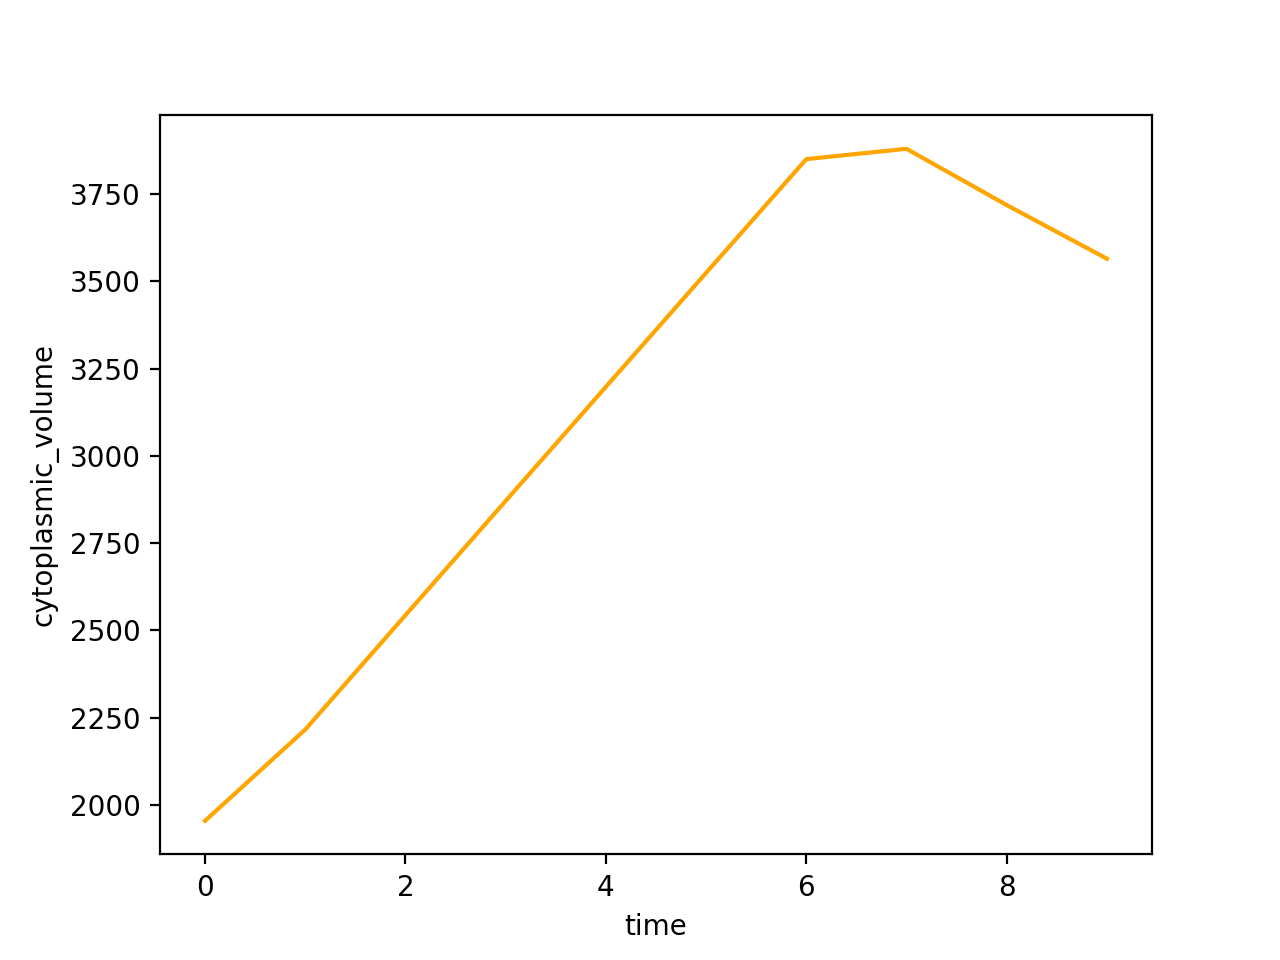

In [8]:
def filterFunction(cells, variables):
    return cells[variables['cycle_model']] == 5

env = InteractiveEnvironment('./sample-output', width=900, height=800)
env.show()

In [11]:
def filterFunction(cells, variables):
    return cells[variables['cycle_model']] != 5

env = InteractiveEnvironment('./sample-output-3d', width=800, height=800)
env.show()

Canvas(height=800, width=800)

RadioButtons(description='Mouse Action:', options=('move', 'zoom', 'rotate', 'select'), value='move')

IntSlider(value=0, continuous_update=False, description='Frame:', max=5)

RadioButtons(description='Generate Attribute Graph:\n', options=('ID', 'position.x', 'position.y', 'position.z…

SelectMultiple(description='Visible:', index=(0,), options=('cell', 'oxygen', 'immunostimulatory factor'), val…

Output()

In [20]:
f = plt.figure('hello')
dir(f)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_xlabel_grp',
 '_align_ylabel_grp',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_constrained',
 '_constrained_layout_pads',
 '_contains',
 '_default_contains',
 '_dpi',
 '_gci',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_layoutbox',
 '_make_key',
 '_mouseover',
 '_normalize_grid_string',
 '_oid',
 '_path_effects',
 '_picker',
 '_process_projection_requirements',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_repr_html_',
 '

<Figure size 432x288 with 0 Axes>

In [21]:
f.get_label()

'hello'

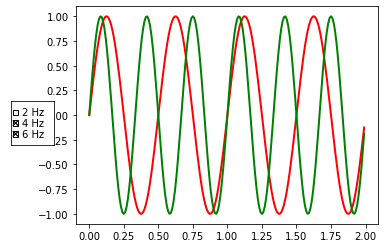

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import CheckButtons

t = np.arange(0.0, 2.0, 0.01)
s0 = np.sin(2*np.pi*t)
s1 = np.sin(4*np.pi*t)
s2 = np.sin(6*np.pi*t)

fig, ax = plt.subplots()
l0, = ax.plot(t, s0, visible=False, lw=2, color='k', label='2 Hz')
l1, = ax.plot(t, s1, lw=2, color='r', label='4 Hz')
l2, = ax.plot(t, s2, lw=2, color='g', label='6 Hz')
plt.subplots_adjust(left=0.2)

lines = [l0, l1, l2]

# Make checkbuttons with all plotted lines with correct visibility
rax = plt.axes([0.05, 0.4, 0.1, 0.15])
labels = [str(line.get_label()) for line in lines]
visibility = [line.get_visible() for line in lines]
check = CheckButtons(rax, labels, visibility)


def func(label):
    index = labels.index(label)
    lines[index].set_visible(not lines[index].get_visible())
    plt.draw()

check.on_clicked(func)

plt.show()